##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Learning to Rank with Decision Forests

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/ranking_colab"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/ranking_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/ranking_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/ranking_colab.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


Welcome to the **Learning to Rank Colab** for **TensorFlow Decision Forests** (**TF-DF**).
In this colab, you will learn how to use **TF-DF** for ranking.

This colab assumes you are familiar with the concepts presented the [Beginner colab](beginner_colab.ipynb), notably about the installation about TF-DF.

In this colab, you will:

1. Learn what a ranking model is.
1. Train a Gradient Boosted Trees models on the LETOR3 dataset.
1. Evaluate the quality of this model.

## Installing TensorFlow Decision Forests

Install TF-DF by running the following cell.

In [2]:
!pip install tensorflow_decision_forests

  Using cached tensorflow_decision_forests-1.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.5 MB)


  Using cached wurlitzer-3.0.3-py3-none-any.whl (7.3 kB)


[Wurlitzer](https://pypi.org/project/wurlitzer/) is needed to display the detailed training logs in Colabs (when using `verbose=2` in the model constructor).

In [3]:
!pip install wurlitzer

## Importing libraries

In [4]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

2023-01-25 12:35:26.737144: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-25 12:35:26.737222: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-25 12:35:26.737231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


The hidden code cell limits the output height in colab.


In [5]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [6]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v1.2.0


## What is a ranking model?

The goal of a [ranking](https://en.wikipedia.org/wiki/Learning_to_rank) model is to **correctly order** items. For example, ranking can be used to select the best *documents* to retrieve following a user *query*.

A common way to represent a Ranking dataset is with a "relevance" score: The order of the elements is defined by their relevance: Items of greater relevance should be before lower relevance items. The cost of a mistake is defined by the difference between the relevance of the predicted item with the relevance of the correct item. For example, miss-ordering two items with respective relevance 3 and 4 is not as bad as miss-ordering two items with respective relevance 1 and 5.

TF-DF expects for ranking datasets to be presented in a "flat" format. A
document+query dataset might look like that:

query | document_id | feature_1 | feature_2 | relevance/label
----- | ----------- | --------- | --------- | ---------------
cat   | 1           | 0.1       | blue      | 4
cat   | 2           | 0.5       | green     | 1
cat   | 3           | 0.2       | red       | 2
dog   | 4           | NA        | red       | 0
dog   | 5           | 0.2       | red       | 0
dog   | 6           | 0.6       | green     | 1

The *relevance/label* is a floating point numerical value between 0 and 5
(generally between 0 and 4) where 0 means "completely unrelated", 4 means "very
relevant" and 5 means "same as the query".

In this example, Document 1 is very relevant to the query "cat", while document 2 is only "related" to cats. There are no documents is really talking about "dog" (the highest relevance is 1 for the document 6). However, the dog query is still expecting to return document 6 (since this is the document that talks the "most" about dogs).

Interestingly, decision forests are often good rankers, and many
state-of-the-art ranking models are decision forests.

## Let's train a Ranking model

In this example, use a sample of the
[LETOR3](https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/#!letor-3-0)
dataset. More precisely, we want to download the `OHSUMED.zip` from [the LETOR3 repo](https://onedrive.live.com/?authkey=%21ACnoZZSZVfHPJd0&id=8FEADC23D838BDA8%21107&cid=8FEADC23D838BDA8). This dataset is stored in the
libsvm format, so we will need to convert it to csv.

In [7]:
archive_path = tf.keras.utils.get_file("letor.zip",
  "https://download.microsoft.com/download/E/7/E/E7EABEF1-4C7B-4E31-ACE5-73927950ED5E/Letor.zip",
  extract=True)

# Path to the train and test dataset using libsvm format.
raw_dataset_path = os.path.join(os.path.dirname(archive_path),"OHSUMED/Data/All/OHSUMED.txt")

    8192/61824018 [..............................] - ETA: 0s

   98304/61824018 [..............................] - ETA: 31s

  565248/61824018 [..............................] - ETA: 11s

 2015232/61824018 [..............................] - ETA: 4s 

 2105344/61824018 [>.............................] - ETA: 5s

 2203648/61824018 [>.............................] - ETA: 7s

 2768896/61824018 [>.............................] - ETA: 6s

 4202496/61824018 [=>............................] - ETA: 5s

 6750208/61824018 [==>...........................] - ETA: 3s

 9756672/61824018 [===>..........................] - ETA: 2s

12591104/61824018 [=====>........................] - ETA: 2s

15532032/61824018 [======>.......................] - ETA: 1s

17645568/61824018 [=======>......................] - ETA: 1s

20979712/61824018 [=========>....................] - ETA: 1s

24133632/61824018 [==========>...................] - ETA: 1s

27271168/61824018 [============>.................] - ETA: 1s

30416896/61824018 [=============>................] - ETA: 0s

33562624/61824018 [===============>..............] - ETA: 0s

36806656/61824018 [================>.............] - ETA: 0s

39854080/61824018 [==================>...........] - ETA: 0s

43311104/61824018 [====================>.........] - ETA: 0s

46145536/61824018 [=====================>........] - ETA: 0s

49299456/61824018 [======================>.......] - ETA: 0s

52396032/61824018 [========================>.....] - ETA: 0s

54534144/61824018 [=========================>....] - ETA: 0s

57589760/61824018 [==========================>...] - ETA: 0s

60825600/61824018 [============================>.] - ETA: 0s

61824018/61824018 [==============================] - 1s 0us/step


Here are the first lines of the dataset:

In [8]:
!head {raw_dataset_path}

The first step is to convert this dataset to the "flat" format mentioned above.

In [9]:
def convert_libsvm_to_csv(src_path, dst_path):
  """Converts a libsvm ranking dataset into a flat csv file.
  
  Note: This code is specific to the LETOR3 dataset.
  """
  dst_handle = open(dst_path, "w")
  first_line = True
  for src_line in open(src_path,"r"):
    # Note: The last 3 items are comments.
    items = src_line.split(" ")[:-3]
    relevance = items[0]
    group = items[1].split(":")[1]
    features = [ item.split(":") for item in items[2:]]

    if first_line:
      # Csv header
      dst_handle.write("relevance,group," + ",".join(["f_" + feature[0] for feature in features]) + "\n")
      first_line = False
    dst_handle.write(relevance + ",g_" + group + "," + (",".join([feature[1] for feature in features])) + "\n")
  dst_handle.close()

# Convert the dataset.
csv_dataset_path="/tmp/ohsumed.csv"
convert_libsvm_to_csv(raw_dataset_path, csv_dataset_path)

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv(csv_dataset_path)

# Display the first 3 examples.
dataset_df.head(3)

,relevance,group,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25
0,2,g_1,3.0,2.079442,0.272727,0.261034,37.330565,11.431241,37.29975,1.138657,...,9.340024,24.808785,0.393091,57.416517,3.294893,25.0231,3.219799,-3.87098,-3.90273,-3.87512
1,0,g_1,3.0,2.079442,0.428571,0.400594,37.330565,11.431241,37.29975,1.814480,...,9.340024,24.808785,0.349205,43.240626,2.654724,23.4903,3.156588,-3.96838,-4.00865,-3.98670
2,2,g_1,0.0,0.000000,0.000000,0.000000,37.330565,11.431241,37.29975,0.000000,...,9.340024,24.808785,0.240319,25.816989,1.551342,15.8650,2.764115,-4.28166,-4.33313,-4.44161


In this dataset, each row represents a pair of query/document (called "group"). The "relevance" tells how much the query matches the document.

The features of the query and the document are merged together in "f1-25". The exact definition of the features is not known, but it would be omething like:

- Number of words in queries
- Number of common words between the query and the document
- Cosinus similarity between an embedding of the query and an embedding of the document.
- ...

Let's convert the Pandas Dataframe into a TensorFlow Dataset:

In [10]:
dataset_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataset_df, label="relevance", task=tfdf.keras.Task.RANKING)

Let's configure and train our Ranking model.

In [11]:
%set_cell_height 400

model = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.RANKING,
    ranking_group="group",
    num_trees=50)

model.fit(dataset_ds)

<IPython.core.display.Javascript object>

Use /tmpfs/tmp/tmpaa6rg4wm as temporary training directory


Reading training dataset...


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:03.843809. Found 16140 examples.


Training model...


2023-01-25 12:35:38.963248: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-01-25 12:35:38.963282: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-01-25 12:35:38.963290: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:01.250392


Compiling model...


[INFO 2023-01-25T12:35:40.201484308+00:00 kernel.cc:1214] Loading model from path /tmpfs/tmp/tmpaa6rg4wm/model/ with prefix d5b1d93f74a54c40
[INFO 2023-01-25T12:35:40.203931047+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2023-01-25T12:35:40.20395708+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model compiled.


We can now look at the quality of the model on the validation dataset. By default, TF-DF trains ranking models to optimize the [NDCG](https://en.wikipedia.org/wiki/Discounted_cumulative_gain). The NDCG is a value between 0 and 1, where 1 is the perfect score. For this reason, -NDCG is the model loss.

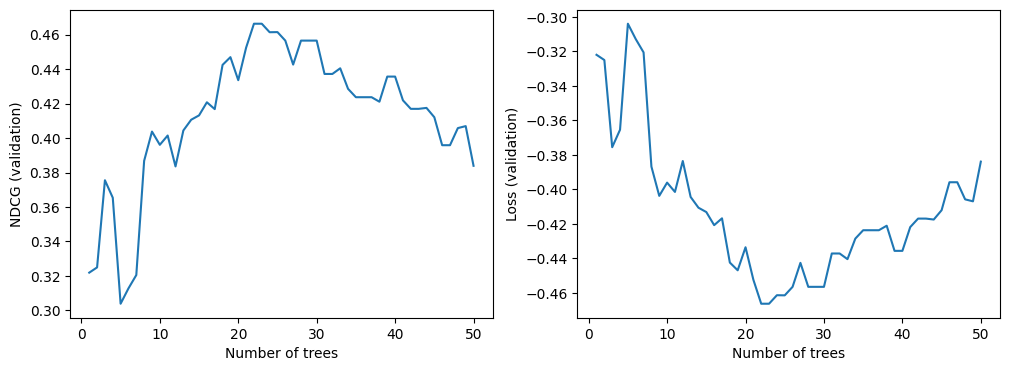

In [12]:
import matplotlib.pyplot as plt

logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.ndcg for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("NDCG (validation)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Loss (validation)")

plt.show()

As for all TF-DF models, you can also look at the model report (Note: The model report also contains the training logs):

In [13]:
%set_cell_height 400
model.summary()

<IPython.core.display.Javascript object>

Model: "gradient_boosted_trees_model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


Total params: 1


Trainable params: 0


Non-trainable params: 1


_________________________________________________________________


Type: "GRADIENT_BOOSTED_TREES"
Task: RANKING
Label: "__LABEL"
Rank group: "group"

Input Features (25):
	f_1
	f_10
	f_11
	f_12
	f_13
	f_14
	f_15
	f_16
	f_17
	f_18
	f_19
	f_2
	f_20
	f_21
	f_22
	f_23
	f_24
	f_25
	f_3
	f_4
	f_5
	f_6
	f_7
	f_8
	f_9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "f_8"  0.311113 ################
    2. "f_23"  0.284303 ############
    3. "f_10"  0.247219 #######
    4. "f_22"  0.214545 ###
    5. "f_19"  0.211207 ###
    6.  "f_4"  0.210856 ###
    7.  "f_9"  0.209961 ###
    8. "f_18"  0.199238 #
    9. "f_25"  0.198938 #
   10. "f_12"  0.198423 #
   11. "f_21"  0.195928 #
   12. "f_16"  0.193692 #
   13.  "f_3"  0.193429 #
   14. "f_15"  0.192216 #
   15. "f_17"  0.189157 
   16. "f_24"  0.188368 
   17. "f_13"  0.187556 
   18. "f_20"  0.186636 
   19.  "f_5"  0.186452 
   20. "f_11"  0.185561 
   21.  "f_6"  0.185416 
   22.  "f_7"  0.184998 
   23. "f_14"  0.184604 
   24.  "f_2"  0.184333 
   25.  "f_1"  0.183540 

Variable Importance: 

And if you are curious, you can also plot the model:

In [14]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)